In [20]:
import pandas as pd
from sklearn.cluster import KMeans
import mplfinance as mpf

In [21]:
df = pd.read_json("../data_set/example.json")
df['avg_price'] = df[['open', 'close', 'high', 'low']].mean(axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       499 non-null    float64
 1   close      499 non-null    float64
 2   high       499 non-null    float64
 3   low        499 non-null    float64
 4   volume     499 non-null    float64
 5   avg_price  499 non-null    float64
dtypes: float64(6)
memory usage: 23.5 KB


In [22]:
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df[['avg_price']])
df['cluster'] = kmeans.labels_
df.head(3)

,open,close,high,low,volume,avg_price,cluster
0,42780.00,42834.94,42901.10,42730.03,173.63661,42811.5175,4
1,42834.94,42961.84,42986.06,42795.41,169.47648,42894.5625,4
2,42961.83,43069.98,43160.86,42914.13,298.77136,43026.7000,4


In [23]:
cluster_info = []
for cluster in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster]
    limitsDown = cluster_data['avg_price'].min()
    limitsUp = cluster_data['avg_price'].max()
    accumulatedVolume = cluster_data['volume'].sum()

    max_volume_idx = cluster_data['volume'].idxmax()
    pivotPrice = cluster_data.loc[max_volume_idx, 'avg_price']
    score = len(cluster_data)
    
    cluster_info.append({
        'cluster': cluster,
        'pivotPrice': pivotPrice,
        'limitsDown': limitsDown,
        'limitsUp': limitsUp,
        'score': score,
        'accumulatedVolume': accumulatedVolume
    })

cluster_sorted: list[dict] = sorted(cluster_info, key=lambda x: x['pivotPrice'])
cluster_result: list[dict] = [{k: v for k, v in d.items() if k != 'cluster'} for d in cluster_sorted]
print(cluster_result)


[{'pivotPrice': 41247.07, 'limitsDown': 40965.2125, 'limitsUp': 41334.82750000001, 'score': 25, 'accumulatedVolume': 11484.42265}, {'pivotPrice': 41541.4925, 'limitsDown': 41350.675, 'limitsUp': 41683.4625, 'score': 44, 'accumulatedVolume': 16764.66682}, {'pivotPrice': 41740.695, 'limitsDown': 41685.535, 'limitsUp': 42090.5675, 'score': 54, 'accumulatedVolume': 25677.978769999998}, {'pivotPrice': 42616.125, 'limitsDown': 42105.2425, 'limitsUp': 42692.68749999999, 'score': 68, 'accumulatedVolume': 28562.038430000004}, {'pivotPrice': 42939.847499999996, 'limitsDown': 42811.5175, 'limitsUp': 43384.869999999995, 'score': 65, 'accumulatedVolume': 29510.197329999995}, {'pivotPrice': 43669.6875, 'limitsDown': 43419.9975, 'limitsUp': 44002.247500000005, 'score': 64, 'accumulatedVolume': 25561.89504}, {'pivotPrice': 45788.325, 'limitsDown': 44330.0825, 'limitsUp': 45788.325, 'score': 13, 'accumulatedVolume': 12449.31098}, {'pivotPrice': 46947.585, 'limitsDown': 46947.585, 'limitsUp': 47633.6625

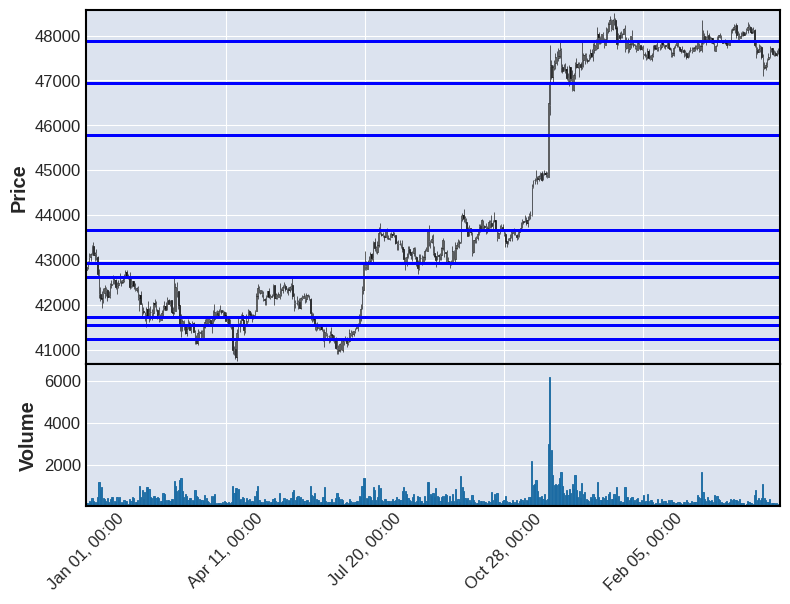

In [24]:
cluster_result: list[dict] = [{k: v for k, v in d.items() if k != 'cluster'} for d in cluster_info]
df['Date'] = pd.date_range('2023-01-01', periods=499)
df['Date'] = pd.to_datetime(df['Date'])
df.index = pd.DatetimeIndex(df['Date'])

sr_lines = [
    item["pivotPrice"]
    for item in cluster_info
]

mpf.plot(
    data=df,
    type='candle',
    tight_layout=True, 
    datetime_format='%b %d, %H:%M', 
    volume=True,
    hlines=dict(
        hlines=sr_lines,
        colors=["b" for _ in range(len(sr_lines))], 
        linewidths=(2)
    )
)